## 1. 필요한 라이블러리 임포트하기

In [ ]:
### Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

### seaborn plot 기본으로 설정
sns.set(style = 'white', context = 'notebook', palette = 'deep')

## 2. 데이터 불러오기 + 확인

In [ ]:
train = pd.read_csv("/content/sample_data/train.csv")
test = pd.read_csv("/content/sample_data/test.csv")
IDtest = test["PassengerId"]

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


이상치 찾기

In [ ]:
### 이상치 탐지를 위한 함수

def detect_outliers(df,n,features):
    """
    피쳐의 데이터 프레임을 가져와서 Tukey 방법에 따라
    n개 이상의 이상치를 포함하는 관측치에 해당하는 인덱스 목록을 반환
    """
    outlier_indices = [ ] # 이상치를 가지는 feature들을 저장
    for col in features: # 각 feature마다
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)

        # Interquartile range (IQR)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR    # iqr*1.5를 벗어나면  outlier에 해당

        # 이상치 탐지
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)

    # 두 개 이상의 이상치를 포함하는 관측치 선택
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

In [ ]:
# 수치형 변수들(Age, SibSp, Parch, Fare)에서 이상치 탐지

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [ ]:
# 이상치가 있는 행 표시

train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
# 이상치 제거

train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
# 이상치가 있는 행을 날린 후 인덱스를 다시 부여

훈련, 테스트 데이터 지정

In [ ]:
# train, test set 결합 - 목적 : 범주형 변수 변환 시 동일한 수의 feature를 얻기 위함

train_len = len(train)
dataset =  pd.concat(objs = [train, test], axis = 0).reset_index(drop = True) # 행을 기준으로

결측치 확인

In [ ]:
# 비어있거나 NaN인 값들을 NaN으로 채움
dataset = dataset.fillna(np.nan)

# 남은 null값 확인
dataset.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            254
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          997
Embarked         2
dtype: int64

In [ ]:
train.info()
print()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  871 non-null    int64  
 1   Survived     871 non-null    int64  
 2   Pclass       871 non-null    int64  
 3   Name         871 non-null    object 
 4   Sex          871 non-null    object 
 5   Age          703 non-null    float64
 6   SibSp        871 non-null    int64  
 7   Parch        871 non-null    int64  
 8   Ticket       871 non-null    object 
 9   Fare         871 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     869 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 81.8+ KB



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            168
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          670
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
train.describe()    # 요약 통계량

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,871.000000,871.000000,871.000000,703.000000,871.000000,871.000000,871.000000
mean,447.381171,0.384615,2.300804,29.795405,0.455798,0.362801,31.327233
std,255.836737,0.486784,0.836790,14.539995,0.873655,0.793186,48.228948
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,228.500000,0.000000,2.000000,20.750000,0.000000,0.000000,7.895800
50%,450.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,38.500000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. 변수 분석

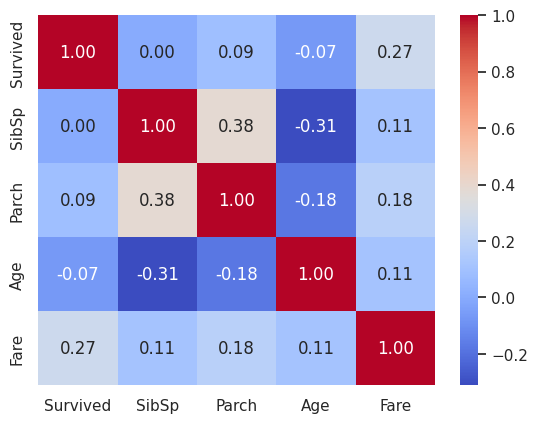

In [ ]:
# 상관계수 행렬
# 수치형 변수들과 Survived 간의 상관계수

g = sns.heatmap(train[["Survived","SibSp","Parch",
                       "Age","Fare"]].corr(),annot = True, fmt = ".2f", cmap = "coolwarm")

fare 변수 : survived변수와 유의한 상관관계 지님

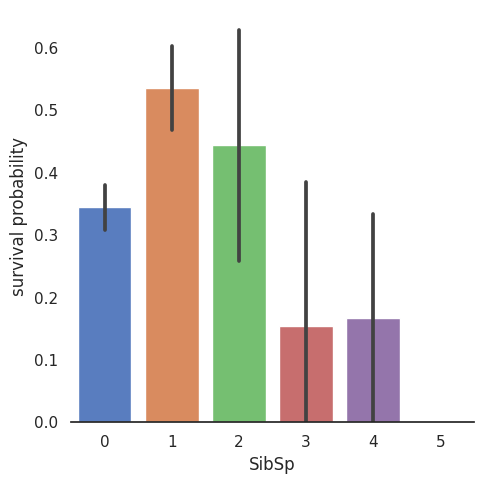

In [ ]:
# sibsp

g = sns.catplot(x = "SibSp",y = "Survived",data = train,
                   kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

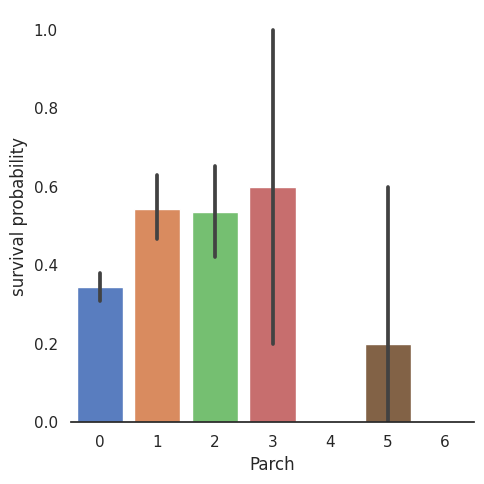

In [ ]:
# parch

g = sns.catplot(x = "Parch",y = "Survived",data = train,
                   kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

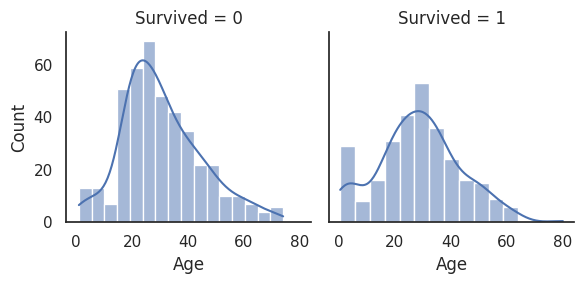

In [ ]:
# age

g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, "Age", kde = True)

<ipython-input-25-61eead012408>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
<ipython-input-25-61eead012408>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],


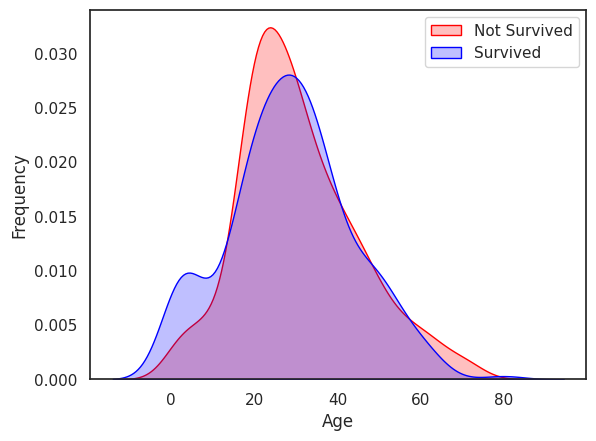

In [ ]:
# 연령대 분포 시각화

g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color = "Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                ax = g, color = "Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [ ]:
# 결측치 확인

dataset["Fare"].isnull().sum()

1

In [ ]:
# 결측치 -> 중간값
# 예측에 중요한 영향을 미치지 않을 것이라고 판단되는 중앙값 채택

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

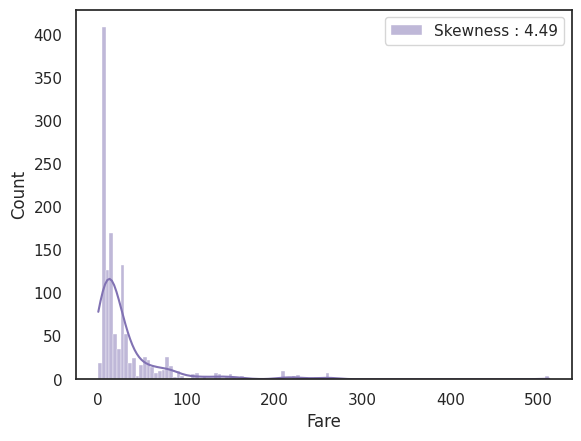

In [ ]:
g = sns.histplot(dataset["Fare"], color="m", kde = True,
                 label = "Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc = "best")

매우 왜곡된 분포 -> 로그변환해서 왜곡 줄이기 !

In [ ]:
# 로그 변환

dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

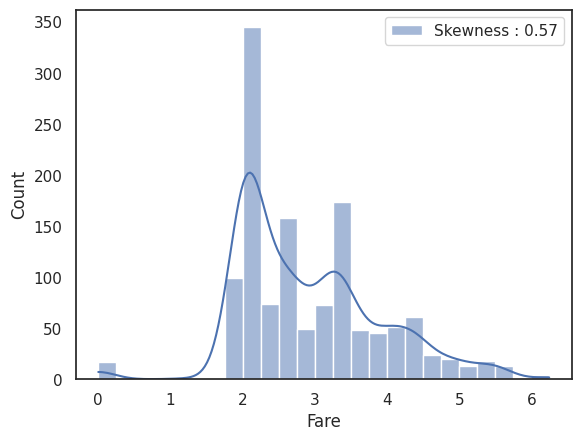

In [ ]:
# 로그 변환 후 시각화

g = sns.histplot(dataset["Fare"], color="b", kde = True,
                 label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

로그변환해서 왜곡정도가 줄어듦 !

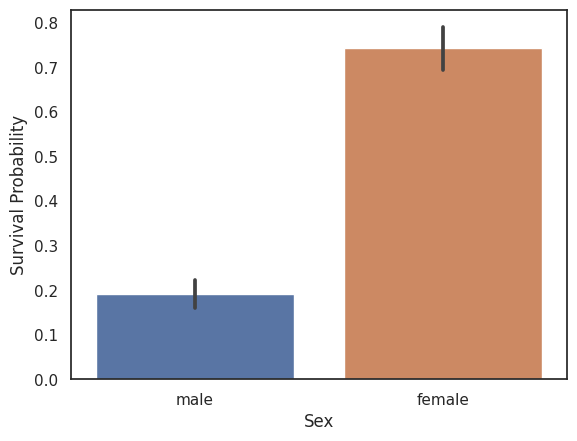

In [ ]:
# sex

g = sns.barplot(x = "Sex",y = "Survived",data = train)
g = g.set_ylabel("Survival Probability")

In [ ]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.744262
male,0.190813


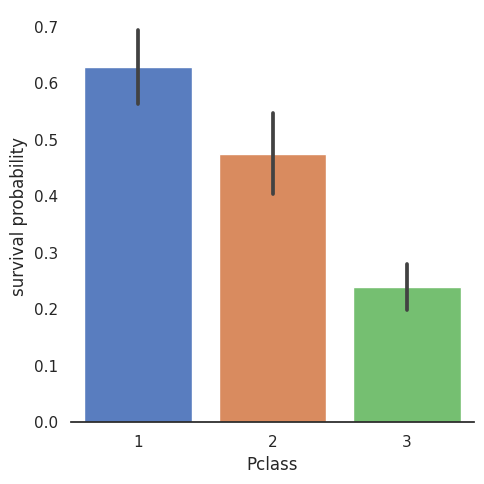

In [ ]:
# pclass

g = sns.catplot(x = "Pclass",y = "Survived",data = train,
                kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

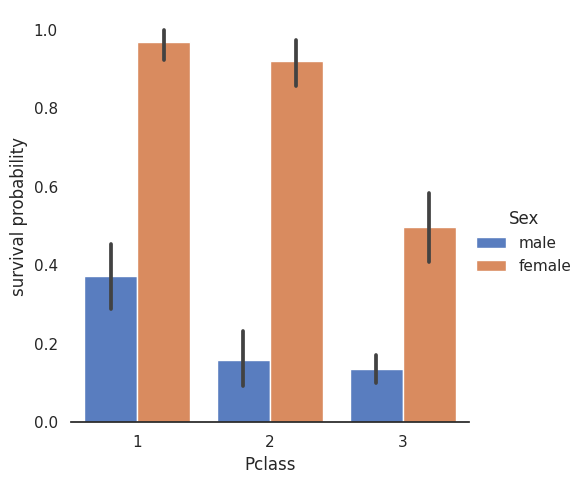

In [ ]:
g = sns.catplot(x = "Pclass", y = "Survived", hue = "Sex",
                   data = train, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

3개의 클래스에 대해 각각의 클래스에서 생존률이 동일하지는 x

In [ ]:
# embarked 결측치 확인
dataset["Embarked"].isnull().sum()

2

In [ ]:
# 결측치 처리
# 가장 많은 'S'로 대체

dataset["Embarked"] = dataset["Embarked"].fillna("S")

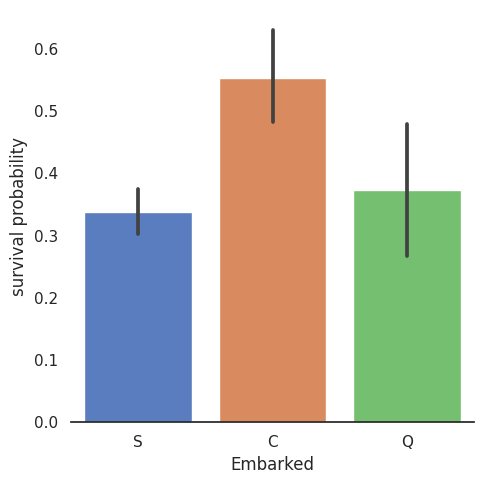

In [ ]:
g = sns.catplot(x = "Embarked", y = "Survived", data = train,
                 kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

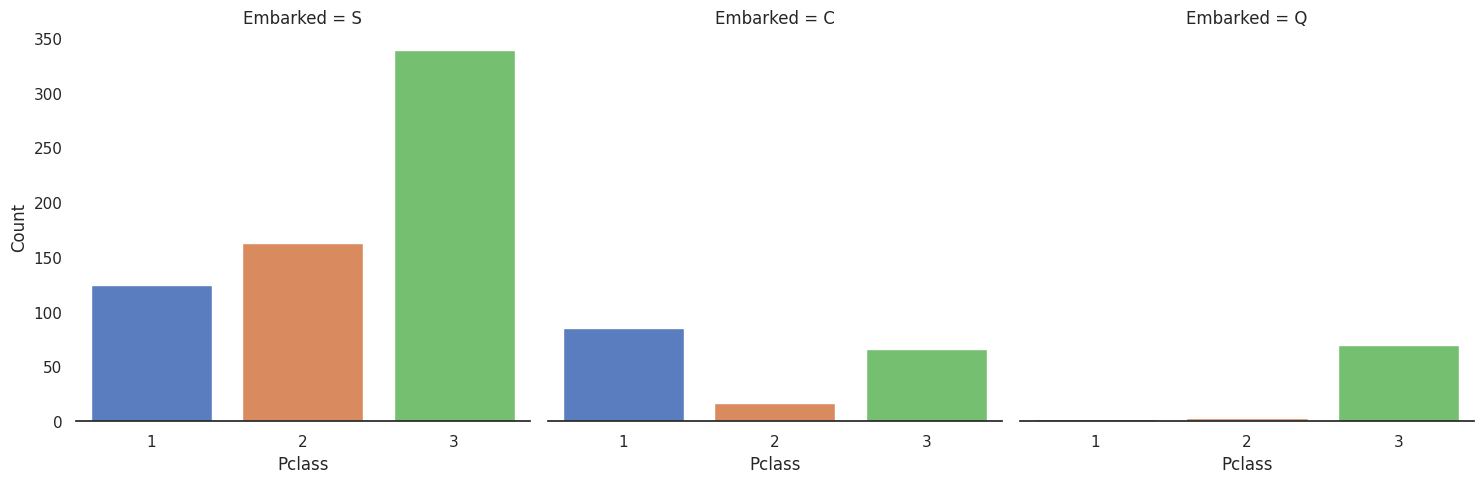

In [ ]:
# PClass vs Embarked

g = sns.catplot(x = "Pclass", col = "Embarked", data = train,
                kind = "count", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Count")

## 4. 결측치 처리

생존 기회가 더 많은 하위집단 존재
- age 변수 유지하고 누락된 값 처리하기
- age 변수와 상관관계 있는 변수들 관찰하기

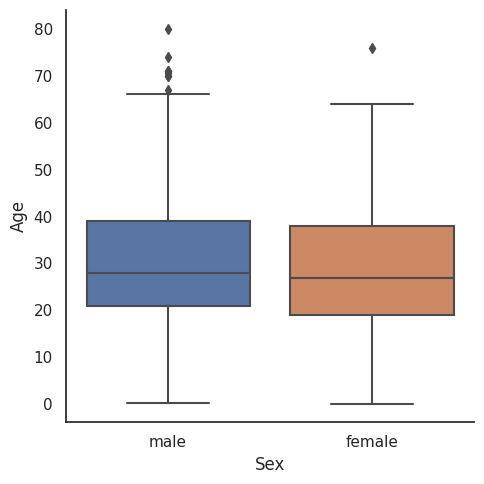

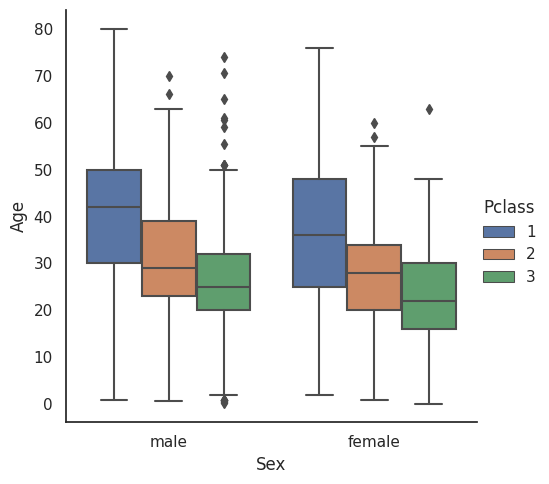

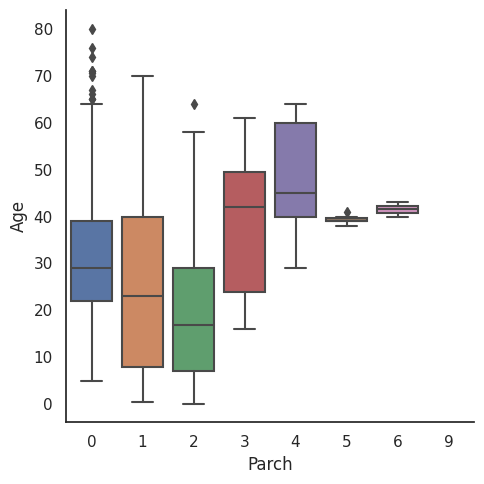

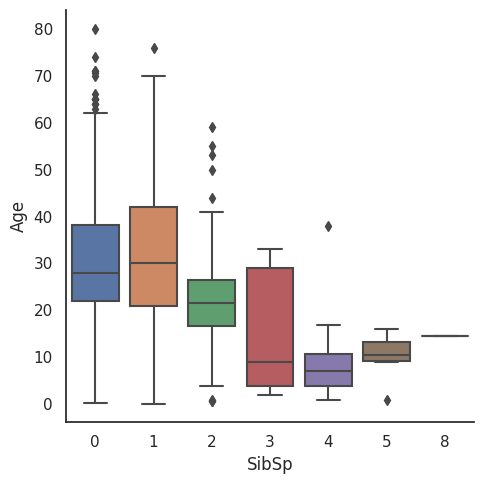

In [ ]:
g = sns.catplot(y = "Age",x = "Sex",data = dataset, kind = "box")
g = sns.catplot(y = "Age", x = "Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

In [ ]:
# Sex(범주형) -> 수치형

dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

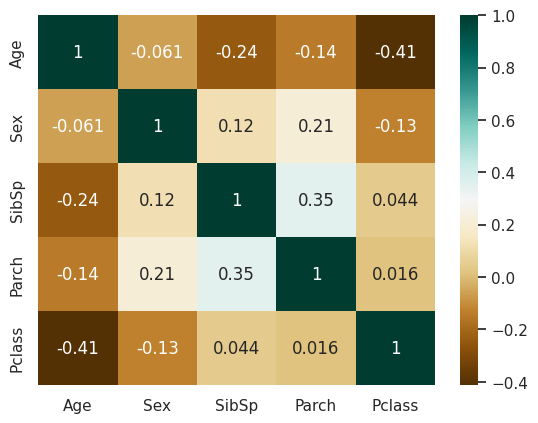

In [ ]:
# 상관계수 heatmap

g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),
                cmap = "BrBG",annot = True)

In [ ]:
# 결측치 처리 -> 중간값으로 대체하기

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index) # 결측치 데이터의 index

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()

    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

<ipython-input-43-2e4037f76be3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-43-2e4037f76be3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-43-2e4037f76be3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-43-2e4037f76be3>:10: SettingWithCopyWarning: 
A value is trying to be set on

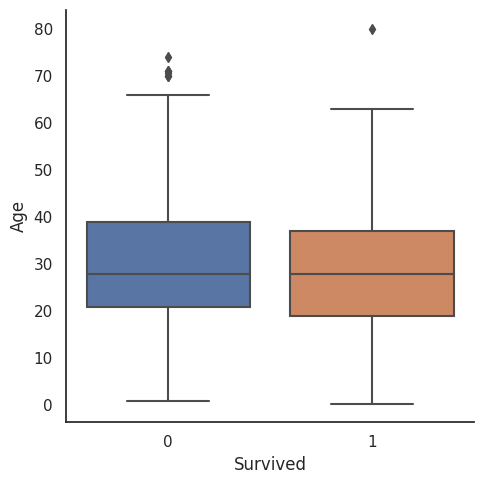

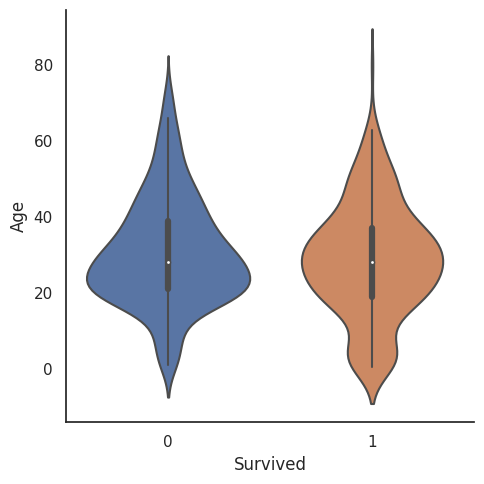

In [ ]:
g = sns.catplot(x = "Survived", y = "Age",data = train, kind = "box")
g = sns.catplot(x = "Survived", y = "Age",data = train, kind = "violin")

## 5. 특성 공학

In [ ]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

승객명에 대한 정보

In [ ]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

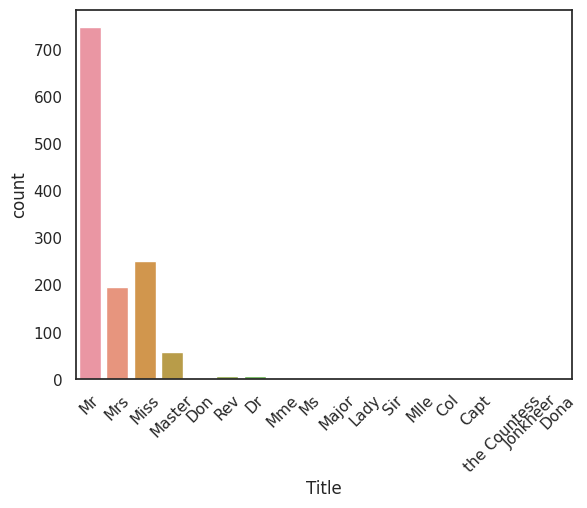

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

거의 없고 4개로 다 구분 가능

In [ ]:
# Title(범주형 변수) -> 수치형 변수

# 4개의 범주로 재분류
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [ ]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

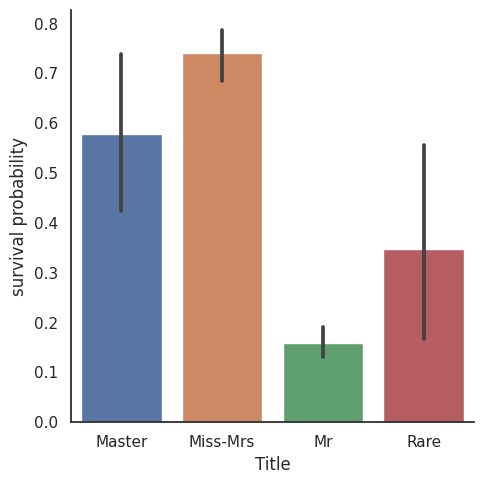

In [ ]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [ ]:
# 기존의 이름 변수를 drop

dataset.drop(labels = ["Name"], axis = 1, inplace = True)

FSize변수 만들기
- FSize : SipSp, Parch + 1(자기자신)

In [ ]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


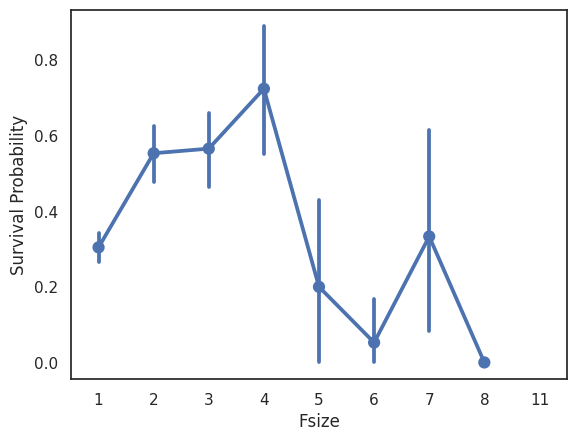

In [ ]:
g = sns.pointplot(x = "Fsize",y = "Survived",data = dataset, )
g = g.set_ylabel("Survival Probability")

가족규모에 따라 생존확률이 달라보이기도 함 -> 그룹화하기

In [ ]:
# 새로운 카테고리 생성
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

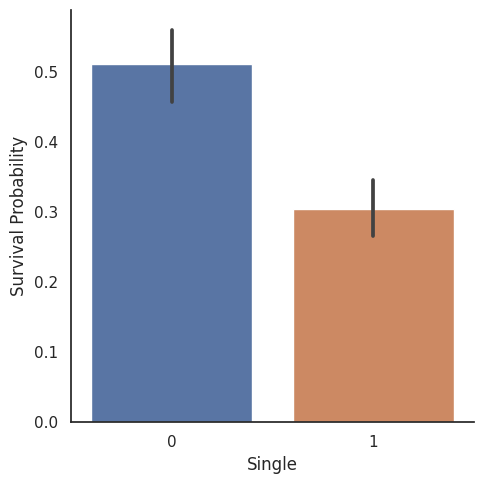

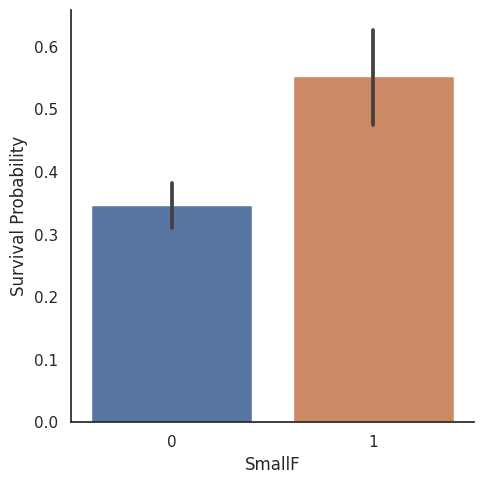

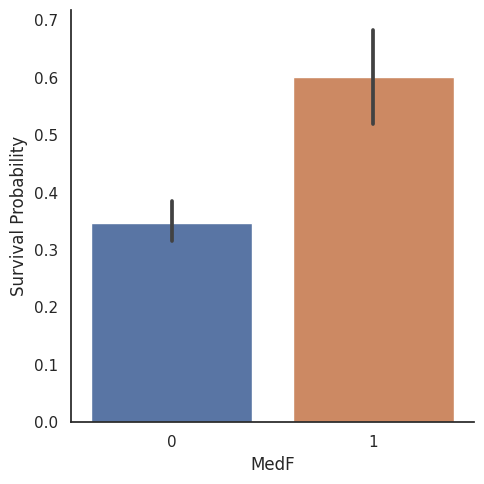

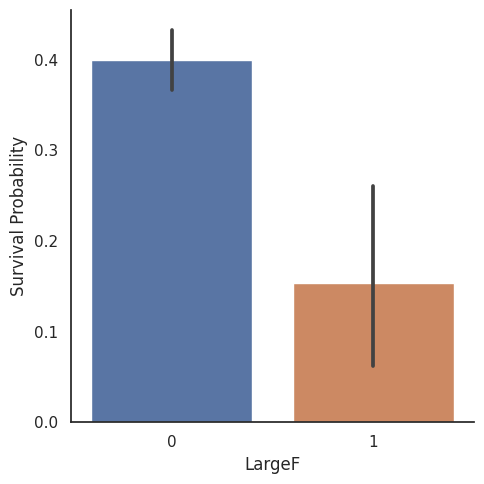

In [ ]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [ ]:
# 수치형 변수로 변환
# One-hot Encoding 진행

dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


22개의 feature 보유

In [ ]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

997

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

객실이 없는 승객 : 누락값이 표시되는 것으로 생각하기

In [ ]:
# 결측치의 경우 'X'로 표기

dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [ ]:
g = sns.countplot(dataset["Cabin"],
                  order=['A','B','C','D','E','F','G','T','X'])

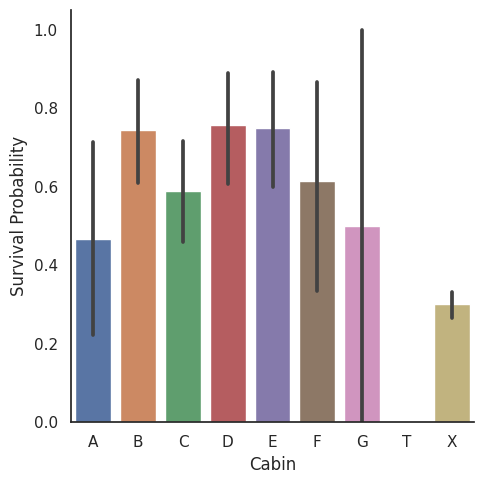

In [ ]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",
                order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [ ]:
# 범주형 변수 -> 수치형 변수

dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [ ]:
# ticket 변수

dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 공유하는 티켓이 함께 배치된 객실에 예약될 수 있다는 것을 의미하는 것일 수 있음
- 실제 선실 배치와 연결될 수 있음

In [ ]:
# 접두어만을 추출
# 만약 없다면 'X'로 표기

Ticket = []
for i in list(dataset.Ticket):
    # 접두어가 있는 경우
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
# One-hot Encoding

dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix = "T")

In [ ]:
# PClass에 대한 범주형 변수 생성

dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix = "Pc")

In [ ]:
# 불필요한 변수 날리기
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. 모델링

In [ ]:
# Train, Test를 다시 나누기

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

<ipython-input-77-177f38bc2511>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [ ]:
# feature(X) vs label(y)

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

<ipython-input-78-65b1a11df491>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


교차 검증 : stratified k-fold 교차검증

In [ ]:
kfold = StratifiedKFold(n_splits = 10)

In [ ]:
# modeling

random_state = 2

# 모델 객체 생성
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

# 교차 검증
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train,
                                      scoring = "accuracy", cv = kfold, n_jobs=4))
# 평가
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest",
                                    "ExtraTrees","GradientBoosting",
                                    "MultipleLayerPerceptron","KNeighboors",
                                    "LogisticRegression","LinearDiscriminantAnalysis"]})

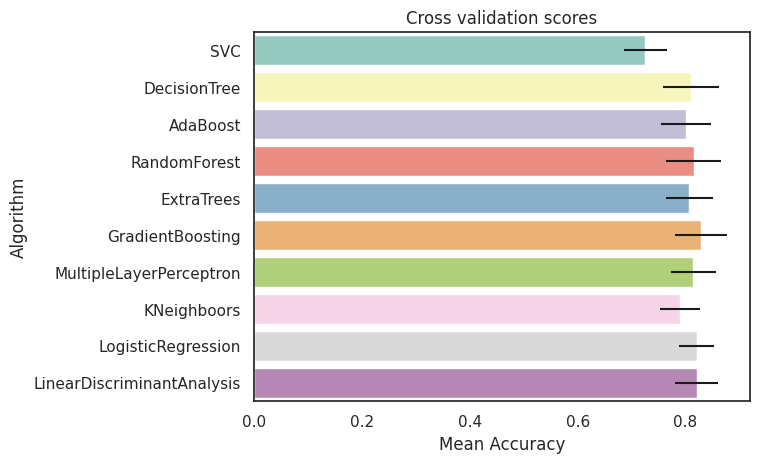

In [ ]:
# 시각화

g = sns.barplot(x = "CrossValMeans",y = "Algorithm",data = cv_res,
                palette = "Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest , ExtraTrees, GradientBoosting 모델 선택

하이퍼 파라미터 튜닝

In [ ]:
# 메타 모델링(Meta Modeling)

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold,
                        scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [ ]:
gsadaDTC.best_score_

0.8221264367816092

In [ ]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold,
                      scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.828983803552769

In [ ]:
# RFC Parameters

RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8312565308254962

In [ ]:
# Gradient boosting

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8289446185997911

In [ ]:
# SVC classifier

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold,
                      scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.831230407523511

시각화하기
- 오버피팅 확인 + 훈련데이터 크기 영향 확인하기

In [ ]:
# 시각화를 위한 함수 정의

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return plt

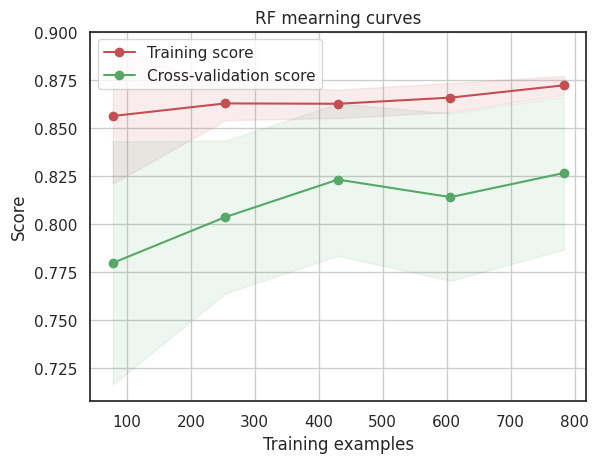

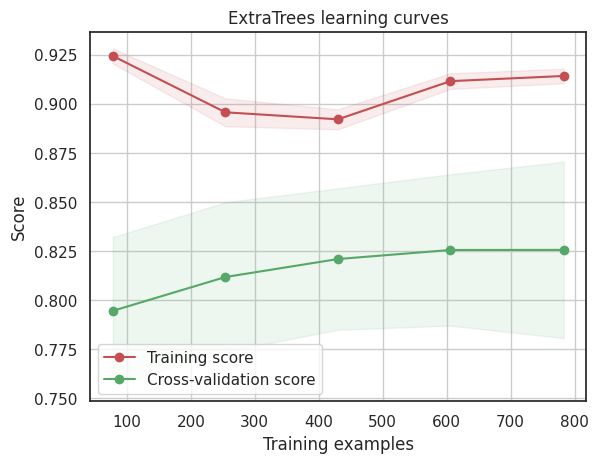

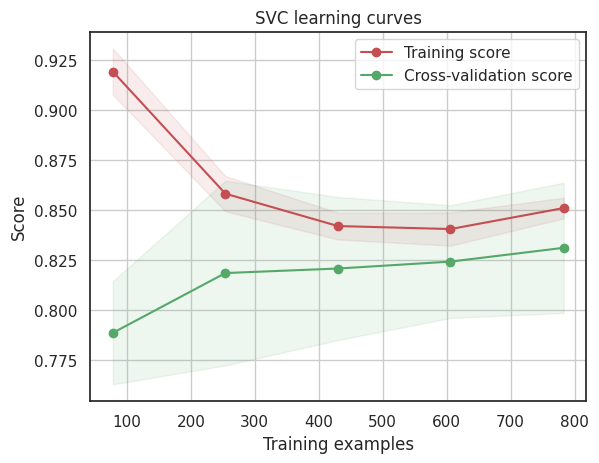

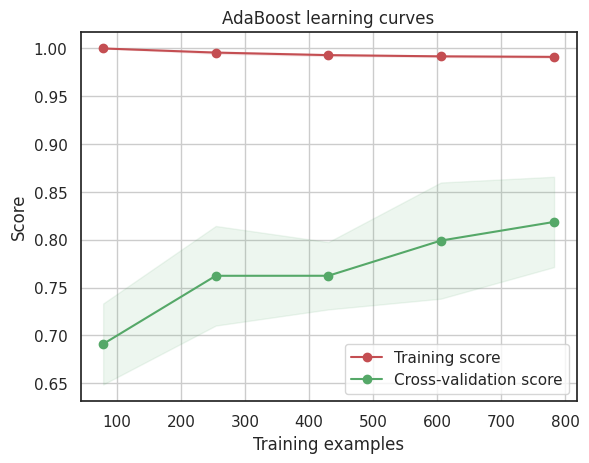

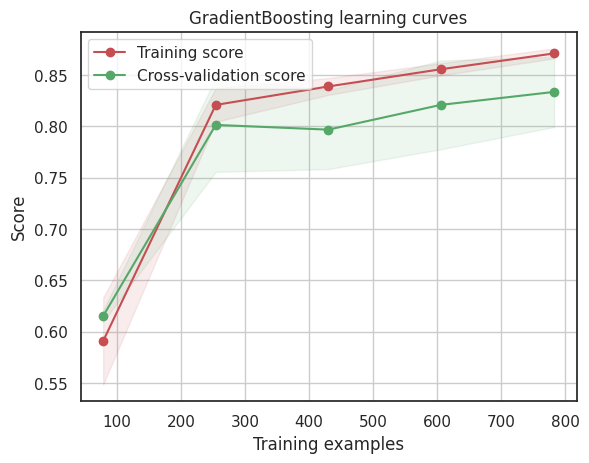

In [ ]:
# 시각화

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",
                        X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",
                        X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",
                        X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",
                        X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",
                        X_train,Y_train,cv=kfold)

GradientBoosting 및 Adaboost 분류기는 훈련 세트에 overfitting된 경향이 있음
- 증가하는 교차 검증 곡선에 따라 GradientBoost와 Adboost는 더 많은 훈련 예제를 통해 더 나은 성능을 발휘할 수 있음


SVC와 ExtraTree 분류기는 훈련과 교차 검증 곡선이 서로 비슷함
- 예측을 더 잘 일반화하는 것으로 보임

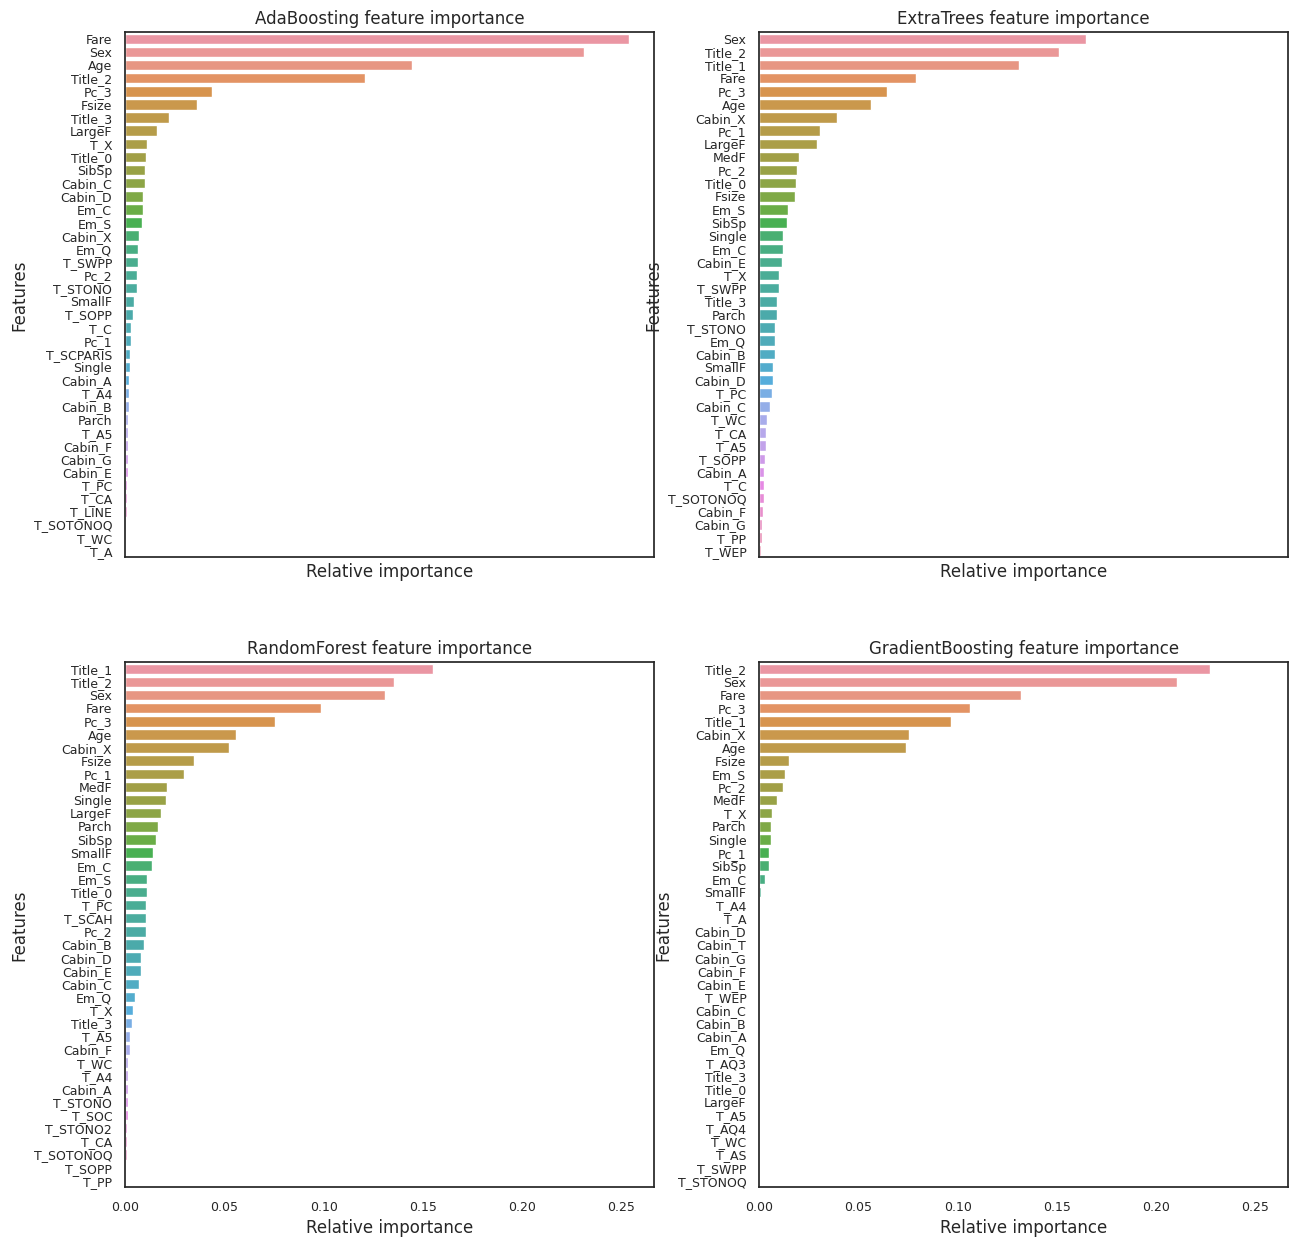

In [ ]:
# 승객의 생존 예측에서 중요한 특징들 파악하기 (피처 중요도)

nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),
                     ("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]

        g = sns.barplot(y = X_train.columns[indices][:40],
                        x = classifier.feature_importances_[indices][:40] ,
                        orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")

        nclassifier += 1

4개의 트리 기반 분류기(Adaboost, ExtraTree, RandomForest 및 GradientBoost)에 대한 feature 중요도를 표시

네 개의 분류기가 상대적 중요성에 따라 다른 최상위 feature 가지고 있음
- 예측이 같은 feature에 근거하지는 않음


Title_2는 Mrs/Mlle/Mme/Miss/Ms 범주가 Sex와 높은 상관관계가 있음
- Discussion:
  - Pc_1, Pc_2, Pc_3 및 요금은 승객의 일반적인 사회적 지위를 나타냄
  - Sex와 Title_2(Mrs/Mlle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 의미
  - 연령과 Title_1(Master)는 승객의 연령
  - Fsize, LargeF, MedF, Single은 승객의 가족 수 크기를 의미

생존 예측은 보트 안의 위치보다는 승객의 나이, 성별, 가족 규모, 사회적 지위와 더 관련이 있음

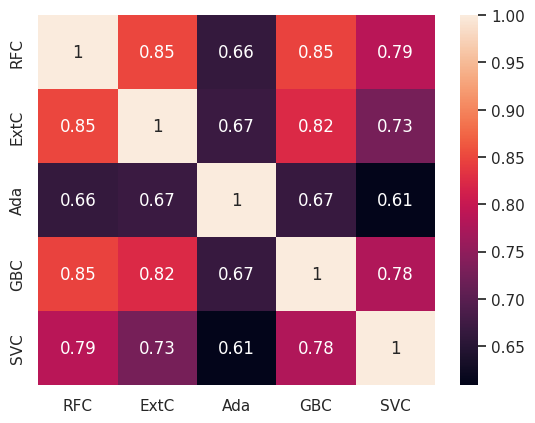

In [ ]:
# 각각의 모델에 대해 예측값 도출
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# 모든 결과 통합
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,
                              test_Survived_GBC, test_Survived_SVMC], axis = 1)

# 시각화
g = sns.heatmap(ensemble_results.corr(),annot=True)

모델 앙상블

In [ ]:
# 모델 결합하기

votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
                                       ('svc', SVMC_best), ('adac',ada_best),
                                       ('gbc',GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

In [ ]:
# 예측 + 결과 확인

test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("ensemble_python_voting.csv",index=False)